In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
%matplotlib inline 

In [4]:
train_img = np.load("train_img.npy")
train_lab = np.load("train_lab.npy")
train_x_noise = np.load('train_adv.npy')
print("train_img's shape: ", train_img.shape)
print("train_lab's shape: ", train_lab.shape)
print("train_x_noise's shape: ", train_x_noise.shape)

train_img's shape:  (550, 100, 784)
train_lab's shape:  (550, 100, 10)
train_x_noise's shape:  (550, 100, 784)


In [5]:
test_img = np.load("test_img.npy")
test_lab = np.load("test_lab.npy")
test_x_noise = np.load('test_adv.npy')
print("test_img's shape: ", test_img.shape)
print("test_lab's shape: ", test_lab.shape)
print("test_x_noise's shape: ", test_x_noise.shape)

test_img's shape:  (100, 100, 784)
test_lab's shape:  (100, 100, 10)
test_x_noise's shape:  (100, 100, 784)


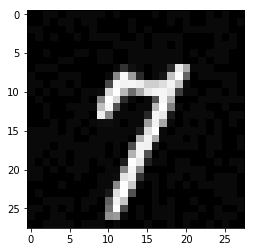

In [6]:
sample_image = train_x_noise[1][2]
sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap = "gray")

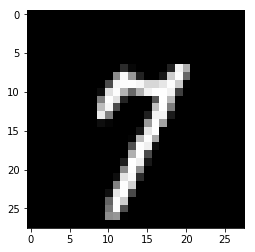

In [7]:
sample_image = train_img[1][2]
sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap = "gray")

In [8]:
# NETOWRK PARAMETERS
n_input    = 784 
n_hidden_1 = 256 
n_hidden_2 = 256 
n_output   = 784  

# PLACEHOLDERS
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_output])
dropout_keep_prob = tf.placeholder("float")

# WEIGHTS
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_output]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_output]))
}

# MODEL
def denoise_auto_encoder(_X, _weights, _biases, _keep_prob):
    layer
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_1out = tf.nn.dropout(layer_1, _keep_prob) 
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1out, _weights['h2']), _biases['b2'])) 
    layer_2out = tf.nn.dropout(layer_2, _keep_prob) 
    return tf.nn.sigmoid(tf.matmul(layer_2out, _weights['out']) + _biases['out'])

# MODEL AS A FUNCTION
reconstruction = denoise_auto_encoder(x, weights, biases, dropout_keep_prob)
print ("NETOWRK READY")

NETOWRK READY


In [9]:
# COST
cost = tf.reduce_mean(tf.pow(reconstruction-y, 2))
# OPTIMIZER
optm = tf.train.AdamOptimizer(1e-3).minimize(cost) 
# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


In [10]:
savedir = "tmp/"
saver   = tf.train.Saver(max_to_keep=1)
print ("SAVER READY")

SAVER READY


START OPTIMIZATION


  0%|                                                  | 0/300 [00:00<?, ?it/s]

Epoch 00/300 average cost: 0.134444


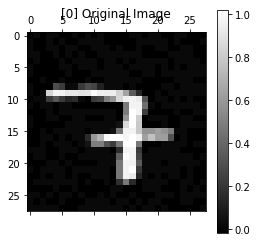

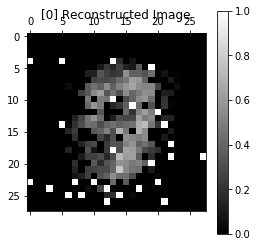

  1%|▌                                         | 4/300 [00:35<44:40,  9.05s/it]

KeyboardInterrupt: 

In [11]:
TRAIN_FLAG = 1
epochs     = 300
batch_size = 100
disp_step  = 10

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(init)
if TRAIN_FLAG:
    print ("START OPTIMIZATION")
    for epoch in tqdm(range(epochs)):
        num_batch  = 550
        total_cost = 0.
        for i in range(num_batch):
            batch_xs = train_img[i].reshape(batch_size, 784)
            batch_ys = train_lab[i].reshape(batch_size, 10)
            batch_xs_noisy = train_x_noise[i].reshape(batch_size, 784)
            feeds = {x: batch_xs_noisy, y: batch_xs, dropout_keep_prob: 1.}
            sess.run(optm, feed_dict=feeds)
            total_cost += sess.run(cost, feed_dict=feeds)
        # DISPLAY
        if epoch % disp_step == 0:
            print ("Epoch %02d/%02d average cost: %.6f" 
                   % (epoch, epochs, total_cost/num_batch))
            # PLOT
#             randidx  = np.random.randint(test_x_noise.shape[0], size=1)
#             testvec  = test_X[randidx, :]
#             noisyvec = testvec + 0.3*np.random.randn(1, 784)
            testvec = test_x_noise[0][0].reshape(1, 784)
            outvec   = sess.run(reconstruction, feed_dict={x: testvec, dropout_keep_prob: 1.})
            outimg   = np.reshape(outvec, (28, 28))
            # Plot 
            plt.matshow(np.reshape(testvec, (28, 28)), cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Original Image")
            plt.colorbar()
            plt.show()
#             plt.matshow(np.reshape(noisyvec, (28, 28)), cmap=plt.get_cmap('gray'))
#             plt.title("[" + str(epoch) + "] Input Image")
#             plt.colorbar()
#             plt.show()
            plt.matshow(outimg, cmap=plt.get_cmap('gray'))
            plt.title("[" + str(epoch) + "] Reconstructed Image")
            plt.colorbar()
            plt.show()
        # SAVE
        saver.save(sess, savedir + 'denoise_auto_encoder.ckpt', global_step=epoch)
print ("OPTIMIZATION FINISHED")

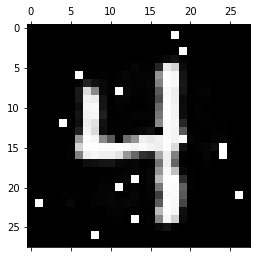

In [12]:
batch_x = test_x_noise[3][0].reshape(-1, 784)
batch_de = sess.run(reconstruction, feed_dict={x: batch_x, dropout_keep_prob: 1.})
plt.matshow(np.reshape(batch_de, (28, 28)), cmap=plt.get_cmap('gray'))

In [13]:
# 在mnist测试集上生成去噪过后的图像
test_de = []
for i in tqdm(range(100)):
    batch_x = test_x_noise[i].reshape(batch_size, 784)
    batch_de = sess.run(reconstruction, feed_dict={x: batch_x, dropout_keep_prob: 1.})
    test_de.append(batch_de)
test_de = np.array(test_de)
np.save('test_de.npy', test_de)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 263.67it/s]


In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [3]:
a = get_available_gpus()
print(a)

['/device:GPU:0']
